# Natural Language Processing with Disaster Tweets

https://www.kaggle.com/c/nlp-getting-started/data

In [28]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/icexelloss/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/icexelloss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
# Read in data
data_fp = os.path.join(os.getcwd(), "data")
train_fp = os.path.join(data_fp, "train.csv")
train = pd.read_csv(train_fp, encoding="utf-8")
test_fp = os.path.join(data_fp, "test.csv")
test = pd.read_csv(test_fp, encoding="utf-8")

print(f"Train: {train.shape}")
print(f"Test:  {test.shape}")

train.head()

Train: (7613, 5)
Test:  (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Exploratory data analysis

- average number of words in disaster vs non-disaster
- average length of tweet 
- average number of disaster vs non disaster per key word
- missing values

Firstly we will check the number of samples that are labelled as disaster (1) and non-disaster (0)

In [30]:
train_label_summary = train.groupby('target').agg(Total = ('id','count'))
train_label_summary['Percentage'] = round(train_label_summary['Total'] / train.shape[0] * 100, 1)
train_label_summary

,Total,Percentage
target,,
0,4342,57.0
1,3271,43.0


This shows us that we have a fairly even split of disaster and non-disaster labelled samples. This is useful when training our model but tell us that this data set is not likely to be representative of the general population of tweets, we know in general there are far less than 43% of tweets that are about disasters.

### Keywords
Next we want to take a look at the keywords and how they relate to the target 

In [31]:
keyword_label_summary = train.groupby('keyword').agg(percentage_disaster_occurance = ('target', 'mean')).reset_index()

keyword_disaster_count = train[train['target'] == 1].groupby('keyword').agg(disaster_count = ('target', 'count')).reset_index()
keyword_not_disaster_count = train[train['target'] == 0].groupby('keyword').agg(not_disaster_count = ('target', 'count')).reset_index()

keyword_label_summary = keyword_label_summary.merge(keyword_disaster_count, how='left')
keyword_label_summary = keyword_label_summary.merge(keyword_not_disaster_count, how='left')


Below are the words that come up most often in disaster tweets.

In [32]:
keyword_label_summary.sort_values('percentage_disaster_occurance', ascending=False).head(20)

,keyword,percentage_disaster_occurance,disaster_count,not_disaster_count
62,debris,1.000000,37.0,NaN
219,wreckage,1.000000,39.0,NaN
70,derailment,1.000000,39.0,NaN
153,outbreak,0.975000,39.0,1.0
152,oil%20spill,0.973684,37.0,1.0
205,typhoon,0.973684,37.0,1.0
187,suicide%20bombing,0.969697,32.0,1.0
186,suicide%20bomber,0.967742,30.0,1.0
32,bombing,0.931034,27.0,2.0
166,rescuers,0.914286,32.0,3.0


Below are the kewords that come up most often in non-disaster tweets. I can see that 'body%20bags' and body%20bag' is a duplicate and needs cleaning up. There are a lot of words here that I would associate with disasters, such as 'ruin', 'explode' and 'wrecked' but these are also words that could be used in a sentence when not describing a disaster.

In [33]:
keyword_label_summary.sort_values('percentage_disaster_occurance', ascending=True).head(20)

,keyword,percentage_disaster_occurance,disaster_count,not_disaster_count
2,aftershock,0.000000,NaN,34.0
29,body%20bags,0.024390,1.0,40.0
170,ruin,0.027027,1.0,36.0
19,blazing,0.029412,1.0,33.0
27,body%20bag,0.030303,1.0,32.0
88,electrocute,0.031250,1.0,31.0
173,screaming,0.055556,2.0,34.0
201,traumatised,0.057143,2.0,33.0
156,panicking,0.060606,2.0,31.0
21,blew%20up,0.060606,2.0,31.0


In [34]:
print(f' Percentage of tweets without a keyword: {round(1 - train.keyword.isna().sum() / train.shape[0] * 100 , 2)}%')

 Percentage of tweets without a keyword: 0.2%


### Length of tweets

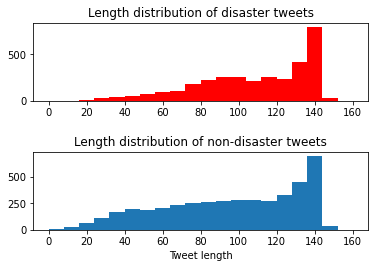

In [35]:
fig, axs = plt.subplots(2)
fig. tight_layout(pad=3.0)

disaster_length = train[train['target'] == 1]['text'].apply(lambda x: len(x))
non_disaster_length = train[train['target'] == 0]['text'].apply(lambda x: len(x))

axs[0].hist(x = disaster_length, color='red', bins=20, range = (0,160))
axs[0].set_title('Length distribution of disaster tweets')
axs[1].hist(x = non_disaster_length, bins=20, range = (0,160))
axs[1].set_title('Length distribution of non-disaster tweets')
axs[1].set_xlabel('Tweet length')

plt.show()

In [36]:
print(f'Average length of disaster tweets is {round(disaster_length.mean())} ' \
 f'with standard deviation {round(disaster_length.std())}')

print(f'Average length of non-disaster tweets is {round(non_disaster_length.mean())} ' \
 f'with standard deviation {round(non_disaster_length.std())}')


Average length of disaster tweets is 108 with standard deviation 29
Average length of non-disaster tweets is 96 with standard deviation 36


### Number of words

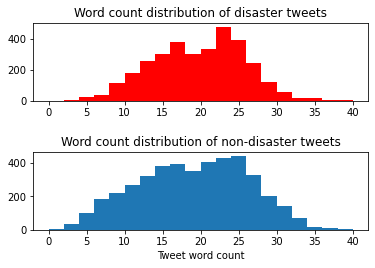

In [37]:
fig, axs = plt.subplots(2)
fig. tight_layout(pad=3.0)

disaster_wc = train[train['target'] == 1]['text'].apply(lambda x: len(word_tokenize(x)))
non_disaster_wc = train[train['target'] == 0]['text'].apply(lambda x: len(word_tokenize(x)))

axs[0].hist(x = disaster_wc, color='red', bins=20, range = (0,40))
axs[0].set_title('Word count distribution of disaster tweets')
axs[1].hist(x = non_disaster_wc, bins=20, range = (0,40))
axs[1].set_title('Word count distribution of non-disaster tweets')
axs[1].set_xlabel('Tweet word count')

plt.show()

## Baseline model

### Split data into train and development
We will reserve 20% of the training data to be used as development data to test iterations of the model against.

In [38]:
# Split into train an development data sets
train_data, dev_data, train_labels, dev_labels = train_test_split(train["text"], \
                                                                  train["target"],\
                                                                  test_size = 0.2, \
                                                                  random_state =24)
print(f'Train data set contains {train_data.shape[0]} samples')
print(f'Development data set contains {dev_data.shape[0]} samples')

Train data set contains 6090 samples
Development data set contains 1523 samples


### Bernoulli Naive Bayes
Starting off with a bernoulli naive bayes model, using the default parameters.   
Using a simple count vectorizer to create a feature space for the model based on the occurance of a word.

F1 score is: 0.8141627446332516


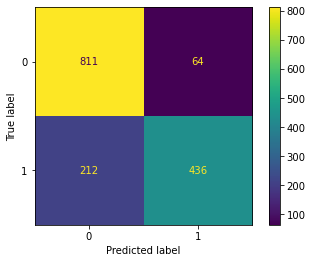

In [39]:
cv = CountVectorizer()
cv.fit(train_data)
train_vec = cv.transform(train_data)
dev_vec = cv.transform(dev_data)

model = BernoulliNB()
model.fit(train_vec, train_labels)
preds = model.predict(dev_vec)

print(f'F1 score is: {metrics.f1_score(dev_labels, preds, average="weighted")}')
metrics.plot_confusion_matrix(model, dev_vec, dev_labels)

Lots of false negatives here. Let's look at what is getting misclassified.

In [40]:
def false_negatives(preds, data):
    print('Classified as negative but are positive')
    print('---------------------------------------\n')
    df = pd.DataFrame()
    df['text'] = data
    df['labels'] = dev_labels
    df['predictions'] = preds
    false_negative = df[(df.labels == 1) & (df.predictions == 0)]
    for i, tweet in zip(false_negative.index, false_negative.text):
        print(f"{i}: {tweet}")

In [41]:
def false_positives(preds, data):
    print('Classified as positive but are negative')
    print('---------------------------------------\n')
    df = pd.DataFrame()
    df['text'] = data
    df['labels'] = dev_labels
    df['predictions'] = preds
    false_positive = df[(df.labels == 0) & (df.predictions == 1)]
    for i, tweet in zip(false_positive.index, false_positive.text):
        print(f"{i}: {tweet}")

In [42]:
false_negatives(preds, dev_data)

Classified as negative but are positive
---------------------------------------

1217: Bradford. Back to doing what we do best. Burning down our own buildings. Read it and weep Leeds. https://t.co/OLnfzb86zb
356: But if you build an army of 100 dogs and their leader is a lion all dogs will fight like a lion.
1408: I'M LAUGHING IN THE FACE OF CASUALTIES AND SORROW THE FIRST TIME I'M THINKING PAST TOMORROW BUT I AM NOT THROWIN AWAY MY SHOT
3564: I've experienced the smell of rotting potatoes for the first time. The Famine must have been awful if the whole country smelled like that.
7313: These wild fires out west are crazy.
5050: On the sneak America has us spoiled. A natural disaster will humble niggas.
632: @APhiABeta1907 w/ugliness due 2 your 'ugly'@AMESocialAction Frat's BIOTERRORISMI'm she who's @FBI ID U $tolewant'g another in my Home.@ABC
2021: @MichaelWestBiz standard damage control
1202: @fewmoretweets all lives matter. Just not a fan of burning down buildings and stealing from 

Lots of these have hyperlinks and @ symbols as well as other special charaters. We can do some preprocessing of the text to help.

Things to try 
1. remove hashtags
3. remove urls

In [43]:
def stem_sentence(text):
    token_words=word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def lem_sentence(text):
    token_words=word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemmer.lemmatize(word, pos='n'))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r"(?:\@)\w+", ' ', text)
    text = re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~?!]+',' ',text)
    text = re.sub(r"[']+",'',text)
    # try subbing 911 or 999 first then dealing with numbers
    #text = re.sub(r'[0-9]+', 'num', text)
    
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    
    text=text.encode("ascii",errors="ignore").decode()

    return text

def clean_and_lem(text):
    return lem_sentence(clean_text(text))

def clean_and_stem(text):
    return stem_sentence(clean_text(text))

### Clean tweets text

F1 score is: 0.81920517904817
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       875
           1       0.86      0.70      0.77       648

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.83      0.82      0.82      1523



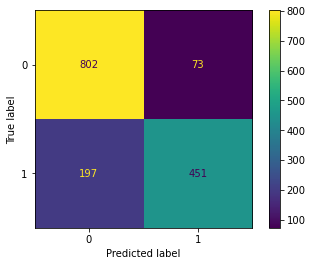

In [44]:
cv = CountVectorizer(analyzer='word', preprocessor=clean_text)
cv.fit(train_data)
train_vec = cv.transform(train_data)
dev_vec = cv.transform(dev_data)

model = BernoulliNB(alpha=0.8)
model.fit(train_vec, train_labels)
preds = model.predict(dev_vec)

print(f'F1 score is: {metrics.f1_score(dev_labels, preds, average="weighted")}')
metrics.plot_confusion_matrix(model, dev_vec, dev_labels)
print(metrics.classification_report(dev_labels, preds))

The recall of the postive samples is pretty low, we need to get that up to see an increase in F1 score.

### Stem words 

F1 score is: 0.8146222445666332
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       875
           1       0.84      0.71      0.77       648

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



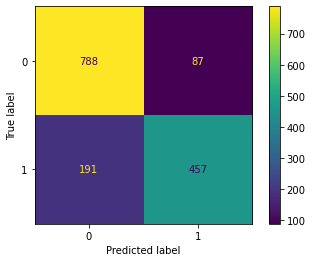

In [45]:
cv = CountVectorizer(analyzer='word', preprocessor=clean_and_stem)
cv.fit(train_data)
train_vec = cv.transform(train_data)
dev_vec = cv.transform(dev_data)

model = BernoulliNB(alpha=0.8)
model.fit(train_vec, train_labels)
preds = model.predict(dev_vec)

print(f'F1 score is: {metrics.f1_score(dev_labels, preds, average="weighted")}')
metrics.plot_confusion_matrix(model, dev_vec, dev_labels)
print(metrics.classification_report(dev_labels, preds))

Stemming has made the number of false positives increase

### Lemmatizing 

F1 score is: 0.822819811554472
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       875
           1       0.86      0.71      0.78       648

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523



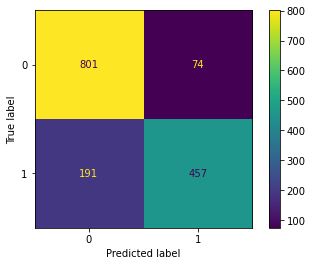

In [46]:
cv = CountVectorizer(analyzer='word', preprocessor=clean_and_lem)
cv.fit(train_data)
train_vec = cv.transform(train_data)
dev_vec = cv.transform(dev_data)

model = BernoulliNB(alpha=0.8)
model.fit(train_vec, train_labels)
preds = model.predict(dev_vec)

print(f'F1 score is: {metrics.f1_score(dev_labels, preds, average="weighted")}')
metrics.plot_confusion_matrix(model, dev_vec, dev_labels)
print(metrics.classification_report(dev_labels, preds))

Looking a bit better. 

### Term Frequency - Inverse Document Frequency 

F1 score is: 0.8222631050585433
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       875
           1       0.86      0.71      0.77       648

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523



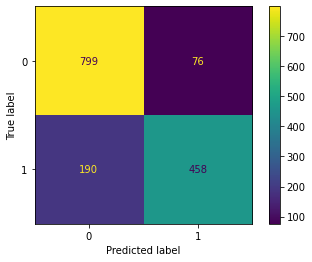

In [47]:
cv = TfidfVectorizer(preprocessor=clean_and_lem, encoding='utf-8',
                       ngram_range=(1,1),
                       max_features=11000, 
                       norm='l2'
                    )
cv.fit(train_data)
train_vec = cv.transform(train_data)
dev_vec = cv.transform(dev_data)
model = BernoulliNB(alpha=0.75)
model.fit(train_vec, train_labels)
preds = model.predict(dev_vec)

print(f'F1 score is: {metrics.f1_score(dev_labels, preds, average="weighted")}')
metrics.plot_confusion_matrix(model, dev_vec, dev_labels)
print(metrics.classification_report(dev_labels, preds))

In [48]:
false_positives(preds, dev_data.apply(lambda x: clean_and_lem(x)))

Classified as positive but are negative
---------------------------------------

6023: exploration take seismic shift in gabon to somalia worldoil ( subscription ) 
6664: generational british schism over privacy threat of drone drone privacy 
2982: islamic state issue a new holiday brochure lovely swimming pool for drowning in shooting range and the downside it cost a bomb 
3202: county 911 overload prompt use of emergency plan during july 4 celebration 
3786: our garbage truck really caught on fire lmfao 
4132: calgary news weather and traffic for august 5 45 
6727: falling asleep to the sound to thousand of river plate fan in the stadium and a thunderstorm vivaargentina 
2823: angry woman openly accuses nema of stealing relief material meant for idp an angry internally displaced wom 
7265: new york a whirlwind day of activity in new york breakfast at the millennium hotel united nation plaza lunch 
4344: [ latest post ] bayelsa poll tension in bayelsa a patience jonathan plan to hijac

In [49]:
false_negatives(preds, dev_data.apply(lambda x: clean_text(x)))

Classified as negative but are positive
---------------------------------------

1217: bradford  back to doing what we do best  burning down our own buildings  read it and weep leeds  
356: but if you build an army of 100 dogs and their leader is a lion all dogs will fight like a lion 
1408: im laughing in the face of casualties and sorrow the first time im thinking past tomorrow but i am not throwin away my shot
3564: ive experienced the smell of rotting potatoes for the first time  the famine must have been awful if the whole country smelled like that 
5050: on the sneak america has us spoiled  a natural disaster will humble niggas 
632:   w ugliness due 2 your ugly  frats bioterrorismim she whos   id u  tolewantg another in my home  
2021:   standard damage control
1202:   all lives matter  just not a fan of burning down buildings and stealing from your neighbors to protest
2793: blue bell may be close to a return from its listeria disaster  hot on  theneeds  recipes 
4518:     wait

# Logstic Regression

F1 score is: 0.8222631050585433
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       875
           1       0.86      0.71      0.77       648

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523



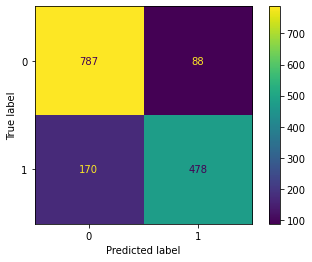

In [50]:
model = LogisticRegression()
model.fit(train_vec, train_labels)
pred = model.predict(dev_vec)

print(f'F1 score is: {metrics.f1_score(dev_labels, preds, average="weighted")}')
metrics.plot_confusion_matrix(model, dev_vec, dev_labels)
print(metrics.classification_report(dev_labels, preds))

# Error Analysis

## Top coefficients

First we look at highest coefficients to see if that makes sense.

In [51]:
feature_index = np.argsort(-model.coef_)[:, :100].flatten()

vocabulary_df = pd.DataFrame({
    'text': cv.vocabulary_.keys(),
    'feature': cv.vocabulary_.values()
}).set_index('feature')

df = pd.DataFrame(model.coef_[:, feature_index]).T
df.index = vocabulary_df.loc[feature_index]
df.columns = ['positive']

print("Table of top 50 features and their coefficients")
print(df.iloc[:50])
print("Table of top 50 - 100 features and their coefficients")
print(df.iloc[50: 100])

Table of top 50 features and their coefficients
                positive
(in,)           3.512272
(fire,)         3.296871
(hiroshima,)    3.063981
(train,)        2.749192
(wildfire,)     2.670357
(california,)   2.562188
(flood,)        2.526278
(storm,)        2.432536
(suicide,)      2.407064
(bombing,)      2.263014
(typhoon,)      2.005593
(police,)       1.959193
(drought,)      1.940606
(derailment,)   1.910626
(mass,)         1.902911
(killed,)       1.880444
(after,)        1.845428
(murder,)       1.843103
(warning,)      1.799792
(car,)          1.755835
(building,)     1.755328
(japan,)        1.746052
(casualty,)     1.744299
(disaster,)     1.742273
(massacre,)     1.738278
(mh370,)        1.727195
(tornado,)      1.724413
(earthquake,)   1.721796
(of,)           1.708967
(report,)       1.678157
(legionnaire,)  1.664775
(war,)          1.630842
(city,)         1.589077
(debris,)       1.583478
(home,)         1.569293
(over,)         1.566876
(near,)         1.551092
(c

## Analysis

At a glance the coefficients are a mixture of 
* indicator of a desaster (wildfire, hailstorm, earthquake, ...) 
* words that can be related to a desaster (catastrophic, police, severe, ...)
* Neutral word (airport, coach, gas, near, ...)

which seem to make sense.

# False Negatives

In [52]:
false_negatives(preds, dev_data.apply(lambda x: clean_text(x)))

Classified as negative but are positive
---------------------------------------

1217: bradford  back to doing what we do best  burning down our own buildings  read it and weep leeds  
356: but if you build an army of 100 dogs and their leader is a lion all dogs will fight like a lion 
1408: im laughing in the face of casualties and sorrow the first time im thinking past tomorrow but i am not throwin away my shot
3564: ive experienced the smell of rotting potatoes for the first time  the famine must have been awful if the whole country smelled like that 
5050: on the sneak america has us spoiled  a natural disaster will humble niggas 
632:   w ugliness due 2 your ugly  frats bioterrorismim she whos   id u  tolewantg another in my home  
2021:   standard damage control
1202:   all lives matter  just not a fan of burning down buildings and stealing from your neighbors to protest
2793: blue bell may be close to a return from its listeria disaster  hot on  theneeds  recipes 
4518:     wait

## Analysis

Looking at false negatives, it appears that some of the test labels can be wrong. For example, these tweets are clearly not disasters but is labeled as so:
* but if you build an army of 100 dogs and their leader is a lion all dogs will fight like a lion
* watch these super strong magnets destroy everyday objects
* check out my lava lamp dude   
* ...

These wrong labels can explain why recall for positive is quite low (0.71).

## False positives

In [53]:
false_positives(preds, dev_data.apply(lambda x: clean_text(x)))

Classified as positive but are negative
---------------------------------------

6023: exploration takes seismic shift in gabon to somalia   worldoil (subscription) 
6664: generational british schism over privacy threat of drones    drones  privacy 
2982:  islamic  state issue a new holiday  brochure lovely swimming pool for drowning in shooting range and the downside it costs a  bomb
3202: county 911 overload prompts use of emergency plan during july 4 celebrations 
3786: our garbage truck really caught on fire lmfao 
4132: calgary news weather and traffic for august 5     45 
6727: falling asleep to the sounds to thousands of river plate fans in the stadium and a thunderstorm   vivaargentina
2823: angry woman openly accuses nema of stealing relief materials meant for idps  an angry internally displaced wom  
7265: new york  a whirlwind day of activities in new york  breakfast at the millennium hotel united nations plaza  lunch  
4344: [latest post] bayelsa poll  tension in bayelsa as

## Analysis

Looking at false positives, some of the tweets are very hard for this model to detect, e.g:

* battlefield 4 funny moments   dukes of hazard undercover soldier mav t  (video game)
* shes a suicide bomb (metaphor)

Some of the false positives are possibily due to the bags of word approach itself:

* advice from noah  dont go running in a thunderstorm

Some of the false postives might get better two a bigram approach:
* the government is concerned about the population explosion and the population is concerned about the government explosion    joe moore (population explosion)
* pizza drought is over i just couldnt anymore (pizza drought)

F1 score is: 0.8222631050585433
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       875
           1       0.86      0.71      0.77       648

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523



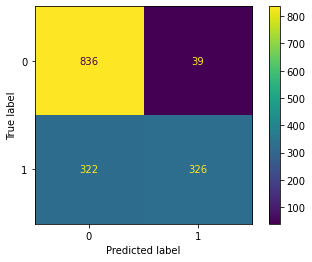

In [54]:
cv = TfidfVectorizer(preprocessor=clean_and_lem, encoding='utf-8',
                       ngram_range=(2,2),
                       norm='l2'
                    )
cv.fit(train_data)
train_vec = cv.transform(train_data)
dev_vec = cv.transform(dev_data)
model = LogisticRegression()
model.fit(train_vec, train_labels)
pred = model.predict(dev_vec)

print(f'F1 score is: {metrics.f1_score(dev_labels, preds, average="weighted")}')
metrics.plot_confusion_matrix(model, dev_vec, dev_labels)
print(metrics.classification_report(dev_labels, preds))